
# EDA · Saber 11 (2016) — Nariño y Pasto · **TFM Data Science**

Este cuaderno desarrolla un **Análisis Exploratorio de Datos (EDA)** profesional sobre la cohorte **Saber 11 – 2016**, con foco en **Nariño** (y corte específico **Pasto**).  
El EDA está **alineado a los objetivos del TFM**: construir una base confiable de entrada para estimar, más adelante, el **Valor Agregado (VA)** y la **Contribución Relativa (CR)** del programa **Ingeniería de Sistemas – Universidad Mariana** al comparar **Saber 11 (entrada)** vs **Saber Pro (salida)**.

### Qué persigue este EDA
- **Calidad de datos**: unificar 2016_1 + 2016_2, limpiar tipos, normalizar textos, validar rangos y duplicados.
- **Caracterización de entrada** (baseline): puntajes globales y por áreas en Nariño / Pasto.
- **Contexto sociodemográfico**: género, estrato, naturaleza del colegio y jornada.
- **Estructuras agregadas** listas para VA/CR**: resúmenes por colegio y municipio exportados como insumo para el modelado.
- **Gráficas explicativas**: cada figura responde a una pregunta de negocio del TFM (ver notas bajo cada gráfico).

> **Nota**: Este cuaderno **no** calcula VA ni CR. Deja listos los **features** de entrada (Saber 11) que luego se cruzarán con **Saber Pro** por cohorte.


In [2]:

import os
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True
})

print("Libs OK")

Libs OK



## 1) Lectura y unión de fuentes

Archivos oficiales ICFES (TXT `;`) de **2016**: primer y segundo semestre.  
**Edite las rutas si cambian los nombres.**


In [3]:

FILE_2016_1 = "Examen_Saber_11_20161.txt"
FILE_2016_2 = "Examen_Saber_11_20162.txt"

# Columnas de interés (tolerante: si falta alguna, el lector no falla)
COLS = [
    # Ubicación y colegio
    "cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion",
    "cole_depto_ubicacion","cole_mcpio_ubicacion",
    "cole_nombre_establecimiento","cole_naturaleza","cole_area_ubicacion","cole_jornada","cole_genero",
    # Estudiante / familia
    "estu_genero","estu_inse_individual","fami_estratovivienda",
    # Puntajes
    "punt_global","punt_matematicas","punt_lectura_critica",
    "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles",
    # Meta
    "periodo"
]

def safe_read(path, cols):
    if not os.path.exists(path):
        print(f"⚠️ No se encontró: {path}")
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(path, sep=";", encoding="latin1", low_memory=False)
    keep = [c for c in cols if c in df.columns]
    return df[keep].copy()

df1 = safe_read(FILE_2016_1, COLS)
df2 = safe_read(FILE_2016_2, COLS)
df = pd.concat([df1, df2], ignore_index=True)
print("Dimensiones combinadas:", df.shape)
df.head(3)

Dimensiones combinadas: (663817, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
0,76.0,76001.0,VALLE,CALI,COLEGIO LEON DE GREIFF,NO OFICIAL,URBANO,MAÃANA,MIXTO,F,64.751228,Estrato 2,301,68,57,55,55,77,20161
1,76.0,76001.0,VALLE,CALI,COLEGIO IDEAS,NO OFICIAL,URBANO,COMPLETA,MIXTO,M,67.463013,Estrato 3,243,39,54,51,50,51,20161
2,8.0,8573.0,ATLANTICO,PUERTO COLOMBIA,INSTITUTO PARA EL DESARROLLO DEL POTENCIAL HUMANO,NO OFICIAL,URBANO,COMPLETA,MIXTO,F,75.559669,Estrato 4,344,78,63,70,66,64,20161



## 2) Limpieza / Normalización

- Tipos numéricos para puntajes y códigos de ubicación.  
- Normalización robusta de textos (quita tildes/espacios no rompibles, mayúsculas).  
- Eliminación de duplicados.


In [4]:

# 2.1 Puntajes a numéricos
punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]
for c in punt_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2.2 Códigos a enteros (si existen)
for c in ["cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# 2.3 Normalizador de texto
def norm_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace("\xa0"," ", regex=False).str.strip()
    s = s.apply(lambda x: "".join(ch for ch in unicodedata.normalize("NFKD", x) if not unicodedata.combining(ch)))
    return s.str.upper()

for c in ["cole_depto_ubicacion","cole_mcpio_ubicacion","cole_nombre_establecimiento","cole_naturaleza",
          "cole_area_ubicacion","cole_jornada","cole_genero","estu_genero","fami_estratovivienda"]:
    if c in df.columns:
        df[c] = norm_text(df[c])

# 2.4 Duplicados
before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

df.info()

Duplicados eliminados: 195
<class 'pandas.core.frame.DataFrame'>
Index: 663622 entries, 0 to 663816
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   cole_cod_depto_ubicacion     573324 non-null  Int64  
 1   cole_cod_mcpio_ubicacion     573324 non-null  Int64  
 2   cole_depto_ubicacion         663622 non-null  object 
 3   cole_mcpio_ubicacion         663622 non-null  object 
 4   cole_nombre_establecimiento  663622 non-null  object 
 5   cole_naturaleza              663622 non-null  object 
 6   cole_area_ubicacion          663622 non-null  object 
 7   cole_jornada                 663622 non-null  object 
 8   cole_genero                  663622 non-null  object 
 9   estu_genero                  663622 non-null  object 
 10  estu_inse_individual         569353 non-null  float64
 11  fami_estratovivienda         663622 non-null  object 
 12  punt_global                  663622 


## 3) Enfoque regional: **Nariño** y **Pasto**

Se aplican filtros por **código** y, como respaldo, por **texto normalizado**.


In [5]:

mask_narino = (
    (("cole_cod_depto_ubicacion" in df.columns) & (df["cole_cod_depto_ubicacion"] == 52))
    | (("cole_depto_ubicacion" in df.columns) & (df["cole_depto_ubicacion"] == "NARINO"))
)

mask_pasto = mask_narino & (
    (("cole_cod_mcpio_ubicacion" in df.columns) & (df["cole_cod_mcpio_ubicacion"] == 52001))
    | (("cole_mcpio_ubicacion" in df.columns) & (df["cole_mcpio_ubicacion"] == "PASTO"))
)

df_narino = df[mask_narino].copy()
df_pasto  = df[mask_pasto].copy()

print("Nariño:", df_narino.shape, " | Pasto:", df_pasto.shape)
display(df_narino.head(3))

Nariño: (17466, 19)  | Pasto: (5141, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
96,52,52001,NARIAO,PASTO,COLEGIO MI PEQUEAO MUNDO GIMNASIO LOS ANDES,NO OFICIAL,URBANO,MAAANA,MIXTO,M,71.361168,ESTRATO 4,200,40,44,35,37,52,20161
116,52,52001,NARIAO,PASTO,COL SAN FRANCISCO JAVIER,NO OFICIAL,URBANO,COMPLETA,MIXTO,M,79.363342,ESTRATO 4,424,95,66,90,90,80,20161
152,52,52001,NARIAO,PASTO,COL SAN FRANCISCO JAVIER,NO OFICIAL,URBANO,COMPLETA,MIXTO,M,79.404144,ESTRATO 4,324,71,60,63,69,53,20161



## 4) Chequeos de calidad

Sanity checks mínimos para garantizar confiabilidad del baseline:
- Porcentaje de nulos en puntajes.
- Rango plausible de puntajes (0–500 aprox.).


In [6]:

# 4.1 Nulos en puntajes (Nariño)
nulls = df_narino[punt_cols].isna().mean().sort_values(ascending=False).to_frame("pct_null")
print("Porcentaje de nulos (Nariño):")
display((nulls*100).round(2))

# 4.2 Rango plausible
rmin = df_narino[punt_cols].min()
rmax = df_narino[punt_cols].max()
rng = pd.DataFrame({"min": rmin, "max": rmax})
print("Rango de puntajes observado (Nariño):")
display(rng)

Porcentaje de nulos (Nariño):


,pct_null
punt_global,0.0
punt_matematicas,0.0
punt_lectura_critica,0.0
punt_sociales_ciudadanas,0.0
punt_c_naturales,0.0
punt_ingles,0.0


Rango de puntajes observado (Nariño):


,min,max
punt_global,12,450
punt_matematicas,0,100
punt_lectura_critica,0,100
punt_sociales_ciudadanas,0,94
punt_c_naturales,0,100
punt_ingles,0,100



## 5) Descriptivos estadísticos (baseline de entrada)

Medidas de tendencia central y dispersión en **Nariño** y **Pasto**.


In [7]:

desc_narino = df_narino[punt_cols].describe().T
desc_pasto  = df_pasto[punt_cols].describe().T

print("Descriptivos — Nariño")
display(desc_narino)
print("Descriptivos — Pasto")
display(desc_pasto)

Descriptivos — Nariño


,count,mean,std,min,25%,50%,75%,max
punt_global,17466.0,259.131570,50.419514,12.0,221.0,258.0,294.0,450.0
punt_matematicas,17466.0,51.203882,12.772808,0.0,42.0,51.0,60.0,100.0
punt_lectura_critica,17466.0,52.394309,9.975422,0.0,45.0,52.0,59.0,100.0
punt_sociales_ciudadanas,17466.0,50.284667,11.161159,0.0,42.0,50.0,58.0,94.0
punt_c_naturales,17466.0,53.376102,10.391904,0.0,46.0,54.0,60.0,100.0
punt_ingles,17466.0,51.976411,11.122199,0.0,44.0,51.0,59.0,100.0


Descriptivos — Pasto


,count,mean,std,min,25%,50%,75%,max
punt_global,5141.0,279.581015,47.069523,98.0,247.0,278.0,312.0,450.0
punt_matematicas,5141.0,55.787395,12.117395,22.0,48.0,55.0,64.0,100.0
punt_lectura_critica,5141.0,55.898269,9.322954,0.0,50.0,56.0,62.0,100.0
punt_sociales_ciudadanas,5141.0,54.386112,10.665361,0.0,47.0,55.0,62.0,94.0
punt_c_naturales,5141.0,57.300914,9.605441,27.0,51.0,57.0,64.0,100.0
punt_ingles,5141.0,56.795954,11.093632,31.0,49.0,56.0,64.0,100.0



## 6) Perfil sociodemográfico (para análisis causal posterior)

Estas distribuciones explican **heterogeneidad de entrada**. Serán controles en modelos de VA/CR (evitan sesgos por composición):
- **Género** (`estu_genero`)
- **Estrato** (`fami_estratovivienda`)
- **Naturaleza del colegio** (`cole_naturaleza`)
- **Jornada** (`cole_jornada`)


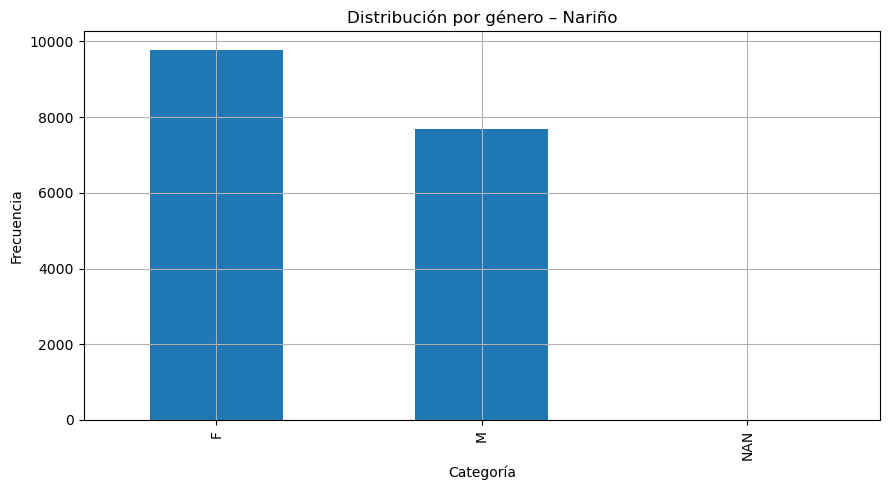

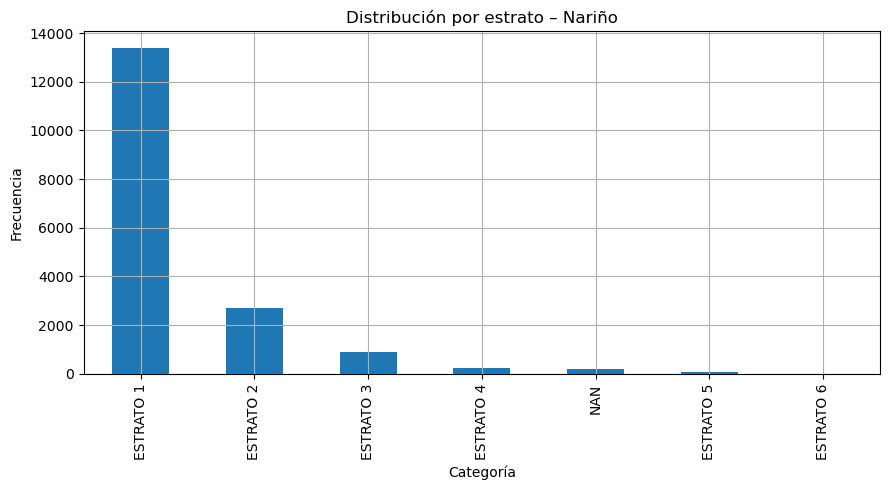

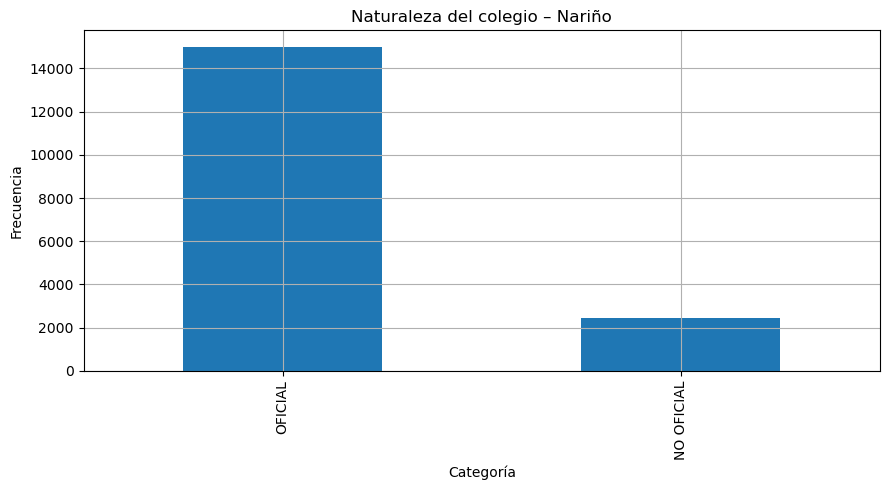

C:\Users\sebas\AppData\Local\Temp\ipykernel_1588\1283191449.py:8: UserWarning: Glyph 145 (\x91) missing from current font.
  plt.tight_layout()
c:\Users\sebas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


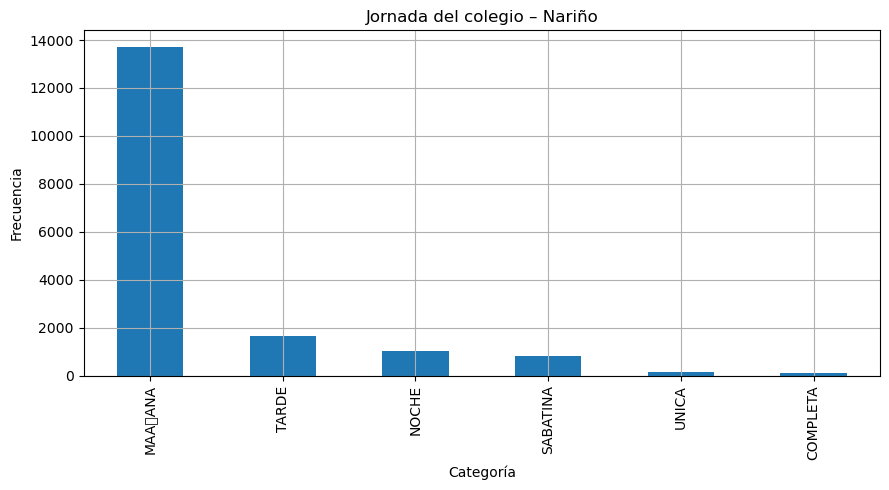

In [8]:

def bar_count(series, title):
    vc = series.value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

if "estu_genero" in df_narino.columns:
    bar_count(df_narino["estu_genero"], "Distribución por género – Nariño")

if "fami_estratovivienda" in df_narino.columns:
    bar_count(df_narino["fami_estratovivienda"], "Distribución por estrato – Nariño")

if "cole_naturaleza" in df_narino.columns:
    bar_count(df_narino["cole_naturaleza"], "Naturaleza del colegio – Nariño")

if "cole_jornada" in df_narino.columns:
    bar_count(df_narino["cole_jornada"], "Jornada del colegio – Nariño")

1. Distribución por género – Nariño

Se observa una participación mayor de mujeres (casi 10.000) frente a hombres (alrededor de 7.700). Este hallazgo es relevante porque la composición de género puede incidir en los resultados agregados y debe ser controlada en el cálculo del VA y CR para evitar sesgos.

2. Distribución por estrato – Nariño

La mayoría de los estudiantes pertenece al estrato 1, seguido de manera distante por el estrato 2 y una proporción mínima en los estratos 3 a 6. Esta concentración en estratos bajos refleja el contexto socioeconómico de la región y constituye un factor explicativo clave en los modelos de predicción: el nivel socioeconómico inicial afecta el desempeño y, por ende, debe incluirse como variable de control.

3. Naturaleza del colegio – Nariño

Predominan los colegios oficiales sobre los no oficiales. Esto evidencia que la mayor parte de los estudiantes accede a educación pública, lo cual puede estar relacionado con diferencias en calidad y recursos respecto a instituciones privadas. Esta variable es fundamental para ajustar las comparaciones al momento de estimar el aporte diferencial de la universidad.

4. Jornada del colegio – Nariño

La jornada de la mañana concentra la gran mayoría de estudiantes, con presencia reducida de las demás modalidades (tarde, noche, completa, sabatina). Esta homogeneidad reduce la influencia de la jornada en el análisis, pero aun así aporta contexto en la caracterización de los estudiantes.


**Uso en el TFM:** estas variables se incorporarán como **controles** al estimar el desempeño esperado en Saber Pro condicional a las características de entrada (baseline), permitiendo aislar el **efecto agregado** atribuible a la formación universitaria.



## 7) Distribución de puntajes (Nariño vs Pasto)

Las curvas y boxplots permiten visualizar **nivel y dispersión** de entrada por territorio.


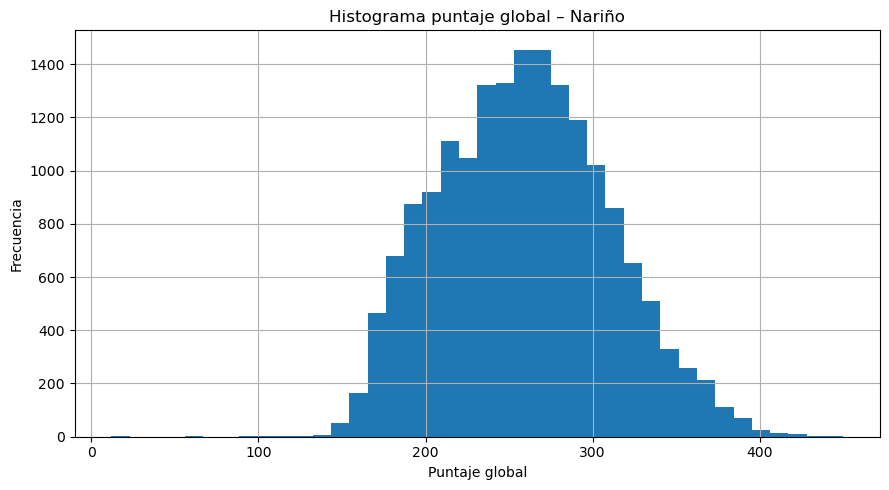

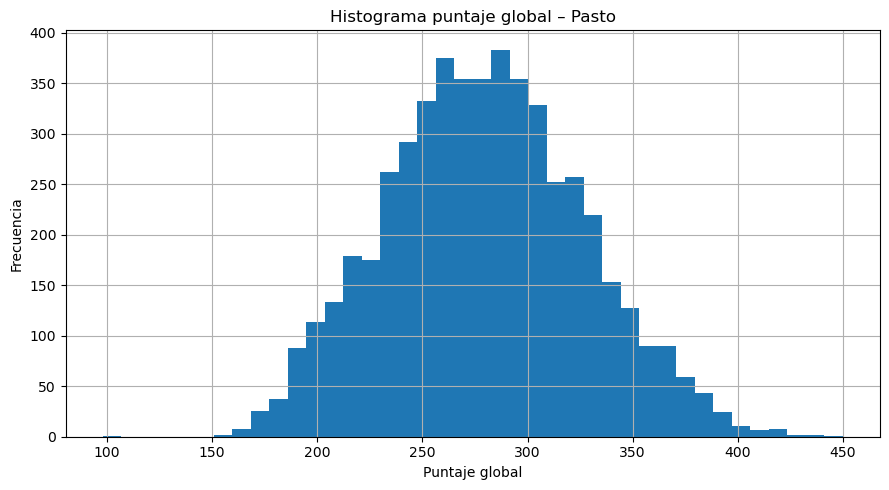

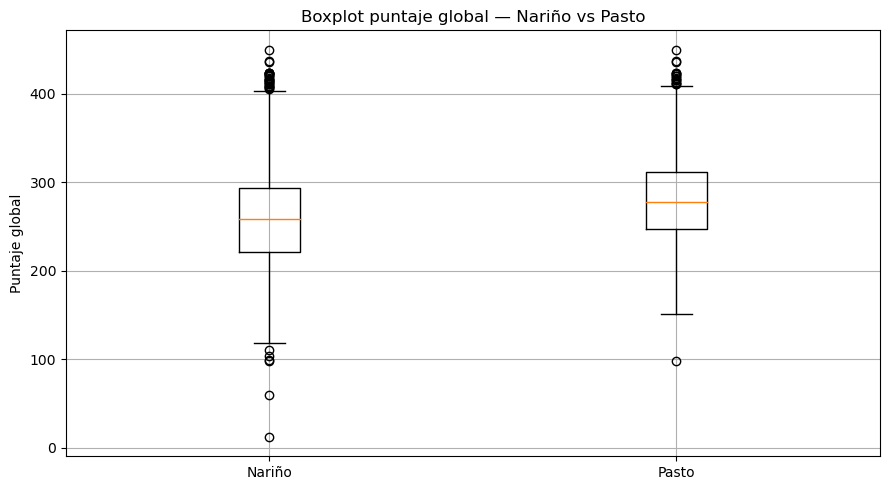

In [9]:

def hist_one(series, title, xlabel):
    if series.notna().any():
        plt.figure()
        series.dropna().plot(kind="hist", bins=40)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

# Hist global
hist_one(df_narino["punt_global"], "Histograma puntaje global – Nariño", "Puntaje global")
hist_one(df_pasto["punt_global"],  "Histograma puntaje global – Pasto",  "Puntaje global")

# Boxplot comparativo
vals, labels = [], []
if df_narino["punt_global"].notna().any():
    vals.append(df_narino["punt_global"].dropna()); labels.append("Nariño")
if df_pasto["punt_global"].notna().any():
    vals.append(df_pasto["punt_global"].dropna());  labels.append("Pasto")

if vals:
    plt.figure()
    plt.boxplot(vals, labels=labels, vert=True)
    plt.title("Boxplot puntaje global — Nariño vs Pasto")
    plt.ylabel("Puntaje global")
    plt.tight_layout()
    plt.show()

5. Histograma de puntaje global – Nariño

La distribución del puntaje global muestra una forma aproximadamente normal, centrada alrededor de los 250 puntos, con pocos casos en los extremos. Esto indica un desempeño medio con una dispersión moderada, lo que será la línea base contra la cual se evaluará el valor agregado al egreso.

6. Histograma de puntaje global – Pasto

En Pasto, la distribución se desplaza ligeramente hacia la derecha en comparación con el total de Nariño, con una concentración más alta entre 260 y 300 puntos. Esto sugiere que los estudiantes de Pasto, como cabecera departamental, parten de un baseline más alto que el promedio del departamento.

7. Boxplot puntaje global – Nariño vs Pasto

El boxplot confirma la diferencia: Pasto presenta una mediana superior al resto de Nariño, además de menor dispersión interna. Esto es un hallazgo central, ya que los cálculos de VA y CR deben reconocer que los estudiantes de Pasto llegan con un nivel inicial más alto.


**Uso en el TFM:** estas figuras justifican los **ajustes de baseline** por territorio (municipio) cuando se calcule VA/CR, y permiten reportar si Pasto difiere sistemáticamente del resto del departamento.



## 8) Comparación por áreas (medias)

Promedios por competencia para Nariño vs Pasto. Útil para identificar **áreas deficitarias** de entrada.


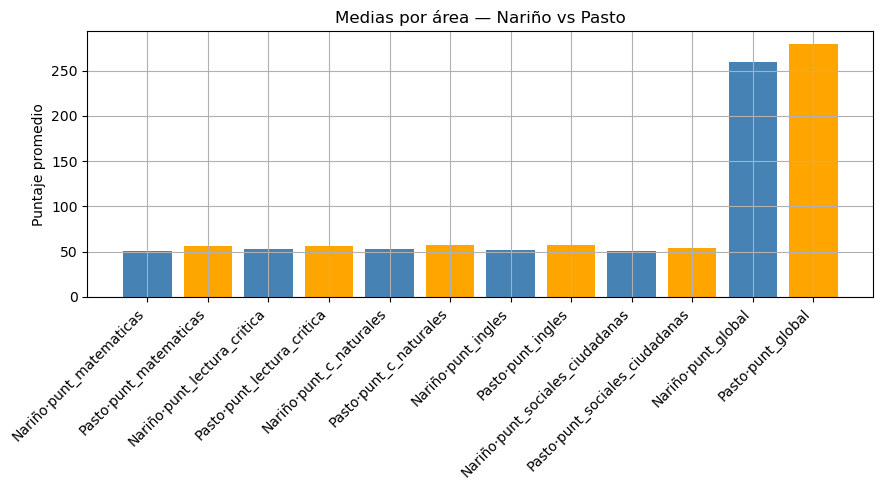

In [10]:
areas = ["punt_matematicas","punt_lectura_critica","punt_c_naturales",
         "punt_ingles","punt_sociales_ciudadanas","punt_global"]

means = []
labels = []
colors = []

for a in areas:
    if a in df_narino.columns:
        means.append(df_narino[a].mean())
        labels.append(f"Nariño·{a}")
        colors.append("steelblue")   # color para Nariño
    if a in df_pasto.columns:
        means.append(df_pasto[a].mean())
        labels.append(f"Pasto·{a}")
        colors.append("orange")      # color para Pasto

plt.figure()
plt.bar(labels, means, color=colors)
plt.title("Medias por área — Nariño vs Pasto")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Puntaje promedio")
plt.tight_layout()
plt.show()


8. Medias por área – Nariño vs Pasto

En todas las áreas (matemáticas, lectura crítica, ciencias naturales, inglés, sociales ciudadanas), Pasto supera levemente los promedios de Nariño. El diferencial más claro se observa en matemáticas e inglés. Esto anticipa que, si el programa universitario logra compensar o ampliar esas diferencias, se podrá evidenciar un VA mayor en esas competencias.


**Uso en el TFM:** orienta hipótesis de **valor agregado diferencial por competencias** (p. ej., si el baseline en matemáticas es bajo, esperar mayor VA si la universidad fortalece esta área).



## 9) Ranking de colegios (Pasto)

Se listan los **Top-10** por puntaje global promedio.  
Esto sirve para construir *perfiles de ingreso* por colegio en la futura plataforma web.


In [11]:

ranking_pasto = pd.DataFrame()
if {"cole_nombre_establecimiento","punt_global"}.issubset(df_pasto.columns):
    ranking_pasto = (df_pasto
                     .groupby("cole_nombre_establecimiento", as_index=False)["punt_global"]
                     .mean()
                     .sort_values("punt_global", ascending=False)
                     .head(10))
    display(ranking_pasto)
else:
    print("No hay columnas suficientes para el ranking.")

,cole_nombre_establecimiento,punt_global
64,LIC INTEGD DE BTO UNIVERSIDAD DE NARIAO,361.215686
13,COL SAN FRANCISCO JAVIER,342.159091
56,INST CHAMPAGNAT,325.232877
15,COLEGIO DEL SAGRADO CORAZON DE JESUS,322.506667
7,COL LA INMACULADA,313.069767
66,LICEO DE LA MERCED MARIDIAZ,311.953125
12,COL SAN FELIPE NERI,311.736364
5,COL FILIPENSE NUESTRA SRA DE LA ESPERANZA,303.866667
26,I.E.M. CIUDAD DE PASTO,302.105943
51,I.E.M. SAN JOSE BETHLEMITAS,299.634615



## 10) Exportación — **Features de entrada** para VA/CR

Se exportan datasets **limpios** y agregados que el pipeline utilizará al cruzar con Saber Pro:
- `s11_2016_narino.csv`, `s11_2016_pasto.csv` → registros individuales filtrados.
- `s11_2016_school_summary.csv` → promedio y tamaño por colegio (Nariño/Pasto).
- `s11_2016_muni_summary.csv` → promedio por municipio (Nariño).


In [37]:
from pathlib import Path
import pandas as pd

# Usa una ruta corta/sencilla (cámbiala si quieres)
out_dir = Path(r"C:\Temp\s11_2016_tfm_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]

muni_summary = df_narino

out_file = out_dir / "s11_2016_muni_summary.csv"
muni_summary.to_csv(str(out_file), index=False, encoding="utf-8-sig")  # <-- str(...)
print("✅ Guardado:", out_file)


✅ Guardado: C:\Temp\s11_2016_tfm_outputs\s11_2016_muni_summary.csv



### Cómo esto alimenta **VA** y **CR**
- Las tablas exportadas representan la **línea base** (entrada) por estudiante/colegio/municipio.  
- En el modelo de VA, **Saber Pro** se explicará como función de `Saber 11 + controles` (género, estrato, naturaleza, municipio).  
- La **Contribución Relativa (CR)** comparará el desempeño del programa contra su **esperado** condicional a este baseline.  
- Este EDA asegura que los datos estén **limpios, coherentes y documentados** para ese emparejamiento por cohorte (2016→2020, etc.).
